In [1]:
#!pip install stellargraph

In [2]:
import os 
import pandas as pd
import numpy as np
import pickle as pkl
import time

import stellargraph as sg
from stellargraph import StellarGraph
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN
from stellargraph import StellarGraph

from stellargraph import datasets

from sklearn import model_selection

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt

## Import the data

In [3]:
file = open("C:/Users/uvmk2/Desktop/project code folder/data/TextGCN_Graph/2309_03022021_adj_mat.pkl",'rb')

graph = pkl.load(file)
label = pkl.load(file)

file.close()    

# create feature matrix 
identity = pd.DataFrame(0, index=graph.nodes, columns=list(range(len(graph.nodes))))
for i in range(identity.shape[1]):
    identity.iloc[i,i] = 1

In [4]:
graph_SG = StellarGraph.from_networkx(graph, node_features=identity)

In [5]:
# one_hot -> single integer
graph_labels = np.array(label).argmax(1)
len(graph_labels)

2225

In [6]:
print(graph_SG.info())
print(np.unique(graph_labels))

StellarGraph: Undirected multigraph
 Nodes: 3313, Edges: 354170

 Node types:
  default: [3313]
    Features: float32 vector, length 3313
    Edge types: default-default->default

 Edge types:
    default-default->default: [354170]
        Weights: range=[0.000109953, 7.84213], mean=0.583003, std=0.965964
        Features: none
[0 1 2 3 4]


In [7]:
generator = FullBatchNodeGenerator(graph_SG, method="gcn")

Using GCN (local pooling) filters...


## Create graph classification model

![](graph_classification_architecture.png)

In [8]:
def create_graph_classification_model(generator):
    
    gc_model = GCN(
        layer_sizes=[64, 5],
        activations=["relu", "softmax"],
        generator=generator,
        dropout=0.0,
    )
    x_inp, x_out = gc_model.in_out_tensors()

    # Let's create the Keras model and prepare it for training
    model = Model(inputs=x_inp, outputs=x_out)
    model.compile(optimizer=Adam(0.005), loss = sparse_categorical_crossentropy, metrics=["acc"])

    return model

## Train the model


In [9]:
model = create_graph_classification_model(generator)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(1, 3313, 3313)]    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(1, None, 2)]       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(1, None)]          0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (1, 3313, 3313)      0           input_1[0][0]                    
_______________________________________________________________________________________

In [10]:
epochs = 100  # maximum number of training epochs
folds = 10  # the number of folds for k-fold cross validation
n_repeats = 1  # the number of repeats for repeated k-fold cross validation

In [11]:
es = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=25, restore_best_weights=True
)

In [12]:
def train_fold(model, train_gen, test_gen, es, epochs):
    history = model.fit(
        train_gen, epochs=epochs, validation_data=test_gen, verbose=0, callbacks=[es]
    )
    # calculate performance on the test data and return along with history
    test_metrics = model.evaluate(test_gen, verbose=0)
    test_acc = test_metrics[model.metrics_names.index("acc")]

    return history, test_acc

In [13]:
test_accs = []
# Cross validation split
stratified_folds = model_selection.RepeatedStratifiedKFold(
    n_splits=folds, n_repeats=n_repeats
).split(graph_labels, graph_labels)


In [14]:
  
for i, (train_index, test_index) in enumerate(stratified_folds):
    print(f"Training and evaluating on fold {i+1} out of {folds * n_repeats}...")
    # (len(graph.nodes) - label.shape[0])  is the number of word nodes 
    train_index2 = train_index +  (len(graph.nodes) - label.shape[0])
    test_index2 =  test_index + (len(graph.nodes) - label.shape[0])

    train_gen = generator.flow(
        train_index2, targets=graph_labels[train_index], use_ilocs=True
    )
    test_gen = generator.flow(
        test_index2, targets=graph_labels[test_index], use_ilocs=True
    )

    model = create_graph_classification_model(generator)
    start_time = time.time()
    history, acc = train_fold(model, train_gen, test_gen, es, epochs)
    print("--- %s seconds ---" % (time.time() - start_time))
    print("Acc: " + str(acc))
    test_accs.append(acc)

Training and evaluating on fold 1 out of 10...
--- 170.15333700180054 seconds ---
Acc: 0.35874438285827637
Training and evaluating on fold 2 out of 10...
--- 170.08970952033997 seconds ---
Acc: 0.3497757911682129
Training and evaluating on fold 3 out of 10...
--- 170.86865735054016 seconds ---
Acc: 0.36771300435066223
Training and evaluating on fold 4 out of 10...
--- 171.00847220420837 seconds ---
Acc: 0.3228699564933777
Training and evaluating on fold 5 out of 10...
--- 170.4981210231781 seconds ---
Acc: 0.3363228738307953
Training and evaluating on fold 6 out of 10...
--- 170.572895526886 seconds ---
Acc: 0.342342346906662
Training and evaluating on fold 7 out of 10...
--- 171.16032123565674 seconds ---
Acc: 0.342342346906662
Training and evaluating on fold 8 out of 10...
--- 170.4063594341278 seconds ---
Acc: 0.37387385964393616
Training and evaluating on fold 9 out of 10...
--- 169.92317724227905 seconds ---
Acc: 0.3558558523654938
Training and evaluating on fold 10 out of 10...
-

In [15]:
print(
    f"Accuracy over all folds mean: {np.mean(test_accs)*100:.3}% and std: {np.std(test_accs)*100:.2}%"
)

Accuracy over all folds mean: 35.1% and std: 1.4%


Text(0, 0.5, 'Count')

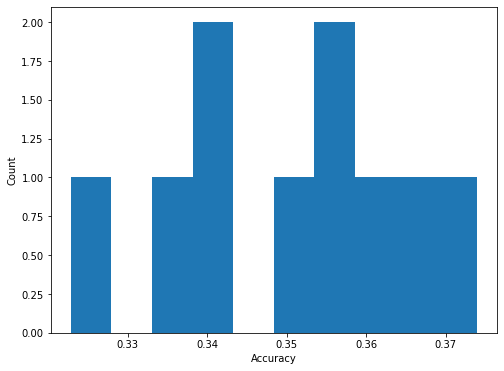

In [16]:
plt.figure(figsize=(8, 6))
plt.hist(test_accs)
plt.xlabel("Accuracy")
plt.ylabel("Count")

# Bert Enchanced GCN

In [3]:
#!pip install pytorch-pretrained-bert pytorch-nlp

In [5]:
# Import Libraries
import re
import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [6]:
df = pd.read_csv("C:/Users/uvmk2/Desktop/project code folder/data/twitter_data.csv")

In [8]:
# Create sentence and label lists
sentences = df.content.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['[CLS]', '@', 'user', 'when', 'a', 'father', 'is', 'dysfunction', '##al', 'and', 'is', 'so', 'selfish', 'he', 'drag', '##s', 'his', 'kids', 'into', 'his', 'dysfunction', '.', '#', 'run', '[SEP]']


In [10]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

In [9]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [10]:
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [11]:
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [12]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [13]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs).to(torch.int64)
validation_inputs = torch.tensor(validation_inputs).to(torch.int64)
train_labels = torch.tensor(train_labels).to(torch.int64)
validation_labels = torch.tensor(validation_labels).to(torch.int64)
train_masks = torch.tensor(train_masks).to(torch.int64)
validation_masks = torch.tensor(validation_masks).to(torch.int64)

In [14]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [15]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

In [16]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [{'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],'weight_decay_rate': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],'weight_decay_rate': 0.0}]

In [17]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,lr=2e-5,warmup=.1)

t_total value of -1 results in schedule not being applied


In [3]:
# Function to calculate the accuracy of our predictions vs labels

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
bert_acc = 0.9586206896551723

In [19]:
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs 
epochs = 2

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    # batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    # batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|                                                                                     | 0/2 [00:00<?, ?it/s]C:\Users\Tru-pro\anaconda3\lib\site-packages\pytorch_pretrained_bert\optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:766.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Train loss: 0.1825608291877672



Epoch:  50%|███████████████████████████████████                                   | 1/2 [6:09:18<6:09:18, 22158.80s/it]

Validation Accuracy: 0.9636530172413793
Train loss: 0.10254890309103885


Epoch: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [9:51:57<00:00, 17758.93s/it]

Validation Accuracy: 0.9586206896551723


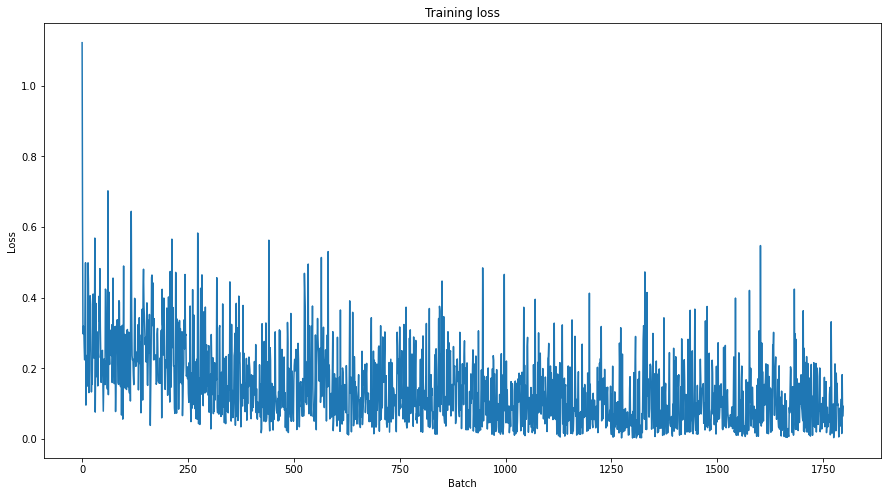

In [20]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

# Evaluate

In [24]:
df = pd.read_csv("data/train.csv")

In [25]:
df.head()

,id,label,sentence
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [26]:
# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids).to(torch.int64)
prediction_masks = torch.tensor(attention_masks).to(torch.int64)
prediction_labels = torch.tensor(labels).to(torch.int64)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [27]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
 # batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [28]:
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

C:\Users\Tru-pro\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


# Deep Learning

In [2]:
from tensorflow.keras.optimizers import Adam, SGD
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, callbacks
from tensorflow.keras import Model, Sequential

from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import re
import string

In [3]:
df = pd.read_csv("C:/Users/uvmk2/Desktop/project code folder/data/twitter_data.csv")

In [32]:
df['content'] = df['content'].str.replace('#', '').str.lower()
df['content'] = df['content'].str.replace('https://', '').str.replace('/', '')

In [33]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\uvmk2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [34]:
def cleaning_text(text):
    stop_words = stopwords.words("english")

    text = re.sub(r'http\S+', " ", text)    # remove urls
    text = re.sub(r'@\w+',' ',text)         # remove mentions
    text = re.sub(r'#\w+', ' ', text)       # remove hastags
    text = re.sub('r<.*?>',' ', text)       # remove html tags
    
    # remove stopwords 
    text = text.split()
    text = " ".join([word for word in text if not word in stop_words])

    for punctuation in string.punctuation:
        text = text.replace(punctuation, "")
    
    return text

In [35]:
df['content'] = df['content'].apply(lambda x: cleaning_text(x))

In [1]:
#print(df['content'])

In [37]:
words = ['Accept', 'Accomplish', 'Achieve', 'Admire', 'Adore', 'Advantage', 'Affirmative', 'Affluent', 'Agree',
         'Amazing','Amaze', 'Appreciate', 'Attractive', 'Authentic', 'Awesome', 'Awe-inspiring', 'Balanced', 'Beautiful','Beuaty','Belief',
         'Blessed', 'Bliss', 'Bold', 'Brave', 'Bright', 'Brilliant', 'Calm', 'Captivating', 'Carefree', 'Celebrate', 
         'Certain', 'Cheerful', 'Clarity', 'Comfort', 'Compassion', 'Confident', 'Connection', 'Conscious', 'Considerate', 
         'Content', 'Courageous', 'Creative', 'Daring', 'Dazzling', 'Delight', 'Desirable', 'Determination', 'Devotion', 
         'Dreamy', 'Dynamic', 'Easygoing', 'Ecstatic', 'Effective', 'Efficient', 'Elegance', 'Empathy', 'Empowered', 'Enjoy'
         , 'Enthusiastic', 'Excellence', 'Excited', 'Exhilarating', 'Expand', 'Expansive', 'Explorative', 'Exquisite', 
         'Faithful', 'Fantastic', 'Fearless', 'Flourishing', 'Flow', 'Focused', 'Fortunate', 'Free', 'Fresh', 'Friendly', 
         'Fun', 'Generosity', 'Genuine', 'Gifted', 'Glorious', 'Glow', 'Gracious', 'Grateful', 'Growth', 'Happy', 
         'Harmony', 'Health', 'Heartfelt', 'Heavenly','Help', 'Helpful', 'Heroic', 'Honest', 'Honorable', 'Hopeful', 'Humble', 
         'Illuminating', 'Imaginative','Impress', 'Impressive', 'Incredible', 'Ingenious', 'Inspired', 'Inspiring', 'Intense', 
         'Intentional', 'Joyful', 'Jubilant', 'Kind', 'Knowledgeable', 'Lively', 'Lovely', 'Luminous', 'Luxurious', 
         'Magical', 'Magnificent', 'Marvelous', 'Meaningful', 'Mindful', 'Miraculous', 'Motivated', 'Natural', 'Nourishing',
         'Nurturing', 'Optimistic', 'Outstanding', 'Passionate', 'Patient', 'Peaceful', 'Perfect', 'Perseverance', 
         'Persistent', 'Playful', 'Pleasant', 'Pleasing', 'Positive', 'Powerful', 'Precious', 'Prepared', 'Productive', 
         'Prosperous', 'Proud', 'Pure', 'Radiant', 'Ready', 'Refreshed', 'Relaxed', 'Reliable', 'Resilient', 'Resourceful', 
         'Rich', 'Romantic', 'Sacred', 'Safe', 'Satisfied', 'Secure', 'Serene', 'Sincere', 'Skillful', 'Smart', 'Smooth', 
         'Soothing', 'Spectacular', 'Spiritual', 'Splendid', 'Spontaneous', 'Strong', 'Stunning', 'Successful', 'Superb', 
         'Supportive', 'Surreal', 'Sweet', 'Swift', 'Sympathetic', 'Thankful', 'Thrilling', 'Thriving', 'Tranquil', 
         'Transformative', 'Transparent', 'Treasured', 'Trusting', 'Truthful', 'Ultimate', 'Unconditional', 'Unforgettable',
         'Unique', 'United', 'Upbeat', 'Uplifting','Valuable','Vibrant', 'Victorious', 'Vigorous', 'Virtuous', 'Visionary', 
        'Vital', 'Vivacious', 'Warm', 'Wealth'
]

In [38]:
dictionary = [word.lower() for word in words]
print(len(words))

202


In [76]:
new_column=[]
for index,val in df['content'].iteritems():
    c=0
    for i in dictionary:
        if(val.__contains__(i)):
            c+=1
    if(c==0):
        l=0
    else:
        l=1
    new_column.append(l)

In [27]:
#print(new_column)

In [78]:
df['label']= new_column

In [79]:
df.head()

,date,id,content,username,label
0,2023-04-14 07:07:05+00:00,1.650000e+18,modi govt getting rich matter recession great...,Vuthaonlinenews,1
1,2023-04-14 07:03:28+00:00,1.650000e+18,wordle 664 56 ⬜⬜🟩🟩⬜ ⬜⬜🟩🟩⬜ ⬜⬜🟩🟩🟩 ⬜🟩🟩🟩🟩 🟩🟩🟩🟩🟩 great,eralc,0
2,2023-04-14 07:01:14+00:00,1.650000e+18,write great value proposition 7 top examples ...,massblogxyz,0
3,2023-04-14 06:58:57+00:00,1.650000e+18,happy dr baba saheb ambedkar jayanti theinvest...,TheInvestmentP1,1
4,2023-04-14 06:58:22+00:00,1.650000e+18,sgvuv isbm birthday great tcobk2nlo7iux,jainbikaneri,0


In [80]:
df.shape

(6644, 5)

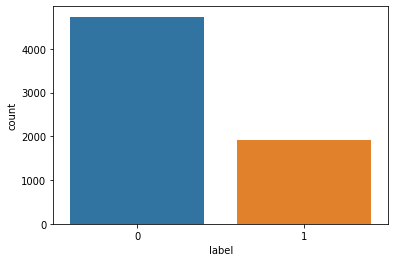

In [81]:
import seaborn as sns
sns.countplot(x="label", data = df)

In [16]:
# Maximum sentence length
max_len_words = max(list(df['content'].apply(len)))
print(max_len_words)

246


In [17]:
def tokenizer(x_train, y_train, max_len_word):
    # because the data distribution is imbalanced, "stratify" is used
    X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                      test_size=.2, shuffle=True, 
                                                      stratify=y_train, random_state=0)

    # Tokenizer
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(X_train)
    sequence_dict = tokenizer.word_index
    word_dict = dict((num, val) for (val, num) in sequence_dict.items())

    # Sequence data
    train_sequences = tokenizer.texts_to_sequences(X_train)
    train_padded = pad_sequences(train_sequences,
                                 maxlen=max_len_word,
                                 truncating='post',
                                 padding='post')
    
    val_sequences = tokenizer.texts_to_sequences(X_val)
    val_padded = pad_sequences(val_sequences,
                                maxlen=max_len_word,
                                truncating='post',
                                padding='post', )
    
    print(train_padded.shape)
    print(val_padded.shape)
    print('Total words: {}'.format(len(word_dict)))
    return train_padded, val_padded, y_train, y_val, word_dict

X_train, X_val, y_train, y_val, word_dict = tokenizer(df.sentence, df.label, 100)

(25569, 100)
(6393, 100)
Total words: 25551


# LSTM

In [1]:

#importing libraries for model evaluation and algorithms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import collections
import nltk
from sklearn import preprocessing
from nltk.tokenize import sent_tokenize, word_tokenize
# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
#dl libraraies
import keras
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization,Reshape,Dot,Concatenate,Add,Lambda
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
#import cv2
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
import os
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from keras.layers.recurrent import LSTM
from keras.preprocessing.sequence import pad_sequences
# specifically for deeplearning.
from tensorflow.keras.layers import Dropout, Flatten,Activation,Input,Embedding
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

Using TensorFlow backend.
C:\Users\uvmk2\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


In [2]:
#reading the dataframe
df=pd.read_csv('C:/Users/uvmk2/Desktop/project code folder/data/train.csv')
df.head()

,id,label,sentence
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,1,#model i love u take with u all the time in ...
4,5,1,factsguide: society now #motivation


In [3]:
#Setting parameters which will be used throughout
num_words = 15000  # Parameter indicating the number of words we'll put in the dictionary
val_size = 1000  # Size of the validation set
epochs = 20  # Number of epochs we usually start to train with
batch_size = 512  # Size of the batches used in the mini-batch gradient descent
#Taking only two columns since it's a sentiment analysis

In [4]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\uvmk2\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\uvmk2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\uvmk2\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\uvmk2\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [7]:
#tweets conssits of every document as an array of tokenized words which are later appended to docs 
tweets=[word_tokenize(tweet) for tweet in df['sentence']]
docs=[]
for j in range(0,len(tweets)):
    docs.append(tweets[j])

In [8]:
#stops included both the stopwords and punctuations
from nltk.corpus import stopwords
import string
stops = set(stopwords.words('english'))
punctuations = list(string.punctuation)
not_list = ["n't", "not", "no"]
stops.update(punctuations)
stops.update(not_list)

In [9]:
#to get the simple pos(part of speech) tag
from nltk.corpus import wordnet
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [10]:
#to get the pos tag for a word
from nltk import pos_tag
# now we are going to clean our data 
# we will remove stopwords and punctuations and lemmatize each document
from nltk.stem import WordNetLemmatizer
lemmatizer=WordNetLemmatizer()
def clean(words):
    output=[]
    for word in words:
        if word.lower() not in stops or word.lower() in not_list:
            pos=pos_tag(word)
            clean_word=lemmatizer.lemmatize(word,pos=get_simple_pos(pos[0][1]))
            output.append(clean_word.lower())
    str1=" ".join(output).encode('utf-8')        
    return str1
#docs=[ clean(doc) for doc in docs]      

In [11]:
#taking only two columns in the dataframe
df=df[['sentence','label']]
df.head()

,sentence,label
0,@user when a father is dysfunctional and is s...,0
1,@user @user thanks for #lyft credit i can't us...,0
2,bihday your majesty,0
3,#model i love u take with u all the time in ...,1
4,factsguide: society now #motivation,1


In [12]:
#taking variables to be used for train test split as X,y
X,Y=df['sentence'].values,pd.get_dummies(df.label.values)

In [13]:
#using tokenizers to create the tokens having no of words=15000(num_words)
tk = Tokenizer(num_words=num_words,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
#Complete data is tokenized to vectors and padding is done using zeros to match its length to the largest text in the dataset.
tk.fit_on_texts(X)
X = tk.texts_to_sequences(X)
X = pad_sequences(X)
#print(X[:2])
print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))
print('Top 5 most common words are:', collections.Counter(tk.word_counts).most_common(5))

Fitted tokenizer on 31962 documents
15000 words in dictionary
Top 5 most common words are: [('user', 17577), ('the', 10165), ('to', 9833), ('a', 6481), ('i', 6170)]


In [14]:
import pickle
pickle.dump(tk,open('transform2.pkl','wb'))
#files.download('transform2.pkl')

In [15]:
#train test split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)
print('# Train data samples:', X_train.shape)
print('# Test data samples:', X_test.shape)

# Train data samples: (25569, 39)
# Test data samples: (6393, 39)


In [16]:
#getting validation data as a part of training data
X_train_rest, X_valid, Y_train_rest, Y_valid = train_test_split(X_train,Y_train, test_size=0.1, random_state=37)
print('Shape of validation set:',X_valid.shape)

Shape of validation set: (2557, 39)


In [17]:
#Function defined to test the models in the test set
def test_model(model, epoch_stop):
    model.fit(X_test
              , Y_test
              , epochs=epoch_stop
              , batch_size=batch_size
              , verbose=0)
    results = model.evaluate(X_test, Y_test)
    
    return results

In [18]:
embed_dim = 128 #dimension of the word embedding vector for each word in a sequence 
lstm_out = 196  #no of lstm layers
lstm_model = Sequential()
lstm_model.add(Embedding(num_words, embed_dim,input_length = X_train.shape[1]))
#Adding dropout
lstm_model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
#Adding a regularized dense layer
lstm_model.add(layers.Dense(32,kernel_regularizer=regularizers.l2(0.001),activation='relu'))
lstm_model.add(layers.Dropout(0.5))
lstm_model.add(Dense(2,activation='softmax'))
lstm_model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(lstm_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 39, 128)           1920000   
_________________________________________________________________
lstm (LSTM)                  (None, 196)               254800    
_________________________________________________________________
dense (Dense)                (None, 32)                6304      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 2,181,170
Trainable params: 2,181,170
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
#model trained on the training data and taking validation data into account to avoid overfitting for 4 epochs 
history_LSTM=lstm_model.fit(X_train_rest, Y_train_rest, epochs = 20, batch_size=batch_size,validation_data=(X_valid, Y_valid),verbose = 1)

Epoch 1/20
45/45 [==============================] - 38s 836ms/step - loss: 0.3545 - accuracy: 0.9226 - val_loss: 0.2397 - val_accuracy: 0.9304
Epoch 2/20
45/45 [==============================] - 45s 997ms/step - loss: 0.1816 - accuracy: 0.9507 - val_loss: 0.1510 - val_accuracy: 0.9578
Epoch 3/20
45/45 [==============================] - 40s 880ms/step - loss: 0.1096 - accuracy: 0.9734 - val_loss: 0.1422 - val_accuracy: 0.9601
Epoch 4/20
45/45 [==============================] - 39s 869ms/step - loss: 0.0740 - accuracy: 0.9846 - val_loss: 0.1516 - val_accuracy: 0.9597
Epoch 5/20
45/45 [==============================] - 34s 764ms/step - loss: 0.0537 - accuracy: 0.9898 - val_loss: 0.1666 - val_accuracy: 0.9625
Epoch 6/20
45/45 [==============================] - 35s 767ms/step - loss: 0.0394 - accuracy: 0.9928 - val_loss: 0.1996 - val_accuracy: 0.9562
Epoch 7/20
45/45 [==============================] - 41s 909ms/step - loss: 0.0313 - accuracy: 0.9950 - val_loss: 0.1927 - val_accuracy: 0.9531

In [20]:
#prediction by our lstm model on the test dataset
lstm_results = test_model(lstm_model, 3)
#print('/n')
print('Test accuracy of lstm model: {0:.2f}%'.format(lstm_results[1]*100))

200/200 [==============================] - 3s 15ms/step - loss: 0.0310 - accuracy: 0.9914
Test accuracy of lstm model: 99.14%


In [21]:
lstm_model.save('lstm_model.h5')

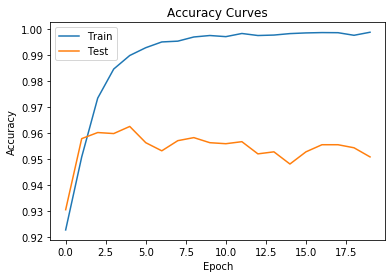

In [22]:
plt.plot(history_LSTM.history['accuracy'])
plt.plot(history_LSTM.history['val_accuracy'])
plt.title('Accuracy Curves')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

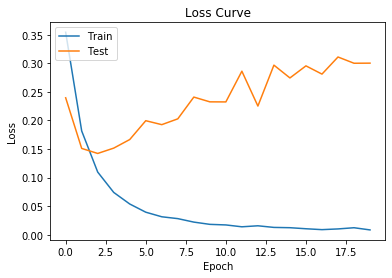

In [25]:
plt.plot(history_LSTM.history['loss'])
plt.plot(history_LSTM.history['val_loss'])
plt.title('Loss Curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# For GCN + LSTM + CNN(Zero Shot)

In [7]:
!pip install BertModelLayer

  ERROR: Could not find a version that satisfies the requirement BertModelLayer (from versions: none)
ERROR: No matching distribution found for BertModelLayer


In [1]:
import pandas as pd
import numpy as np
import json
import re
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, roc_auc_score

In [2]:
import tensorflow as tf
import transformers
import bert 
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer 
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
df_train = pd.read_csv('C:/Users/uvmk2/Desktop/project code folder/data/train.csv')
df_val = pd.read_csv('C:/Users/uvmk2/Desktop/project code folder/data/train.csv')
df_test = pd.read_csv('C:/Users/uvmk2/Desktop/project code folder/data/train.csv')

In [4]:
def get_metrics(y_test, y_pred_proba):
    print('ACCURACY_SCORE: ', round(accuracy_score(y_test, y_pred_proba >= 0.5), 4))
    print('F1_SCORE: ', round(f1_score(y_test, y_pred_proba >= 0.5, average = "macro"), 4))
    print('ROC_AUC_SCORE: ', round(roc_auc_score(y_test, y_pred_proba), 4))
    print('CONFUSION_MATRIX:\n', confusion_matrix(y_test, y_pred_proba >= 0.5),'\n')

In [5]:
#Removes Punctuations
def remove_punctuations(data):
    punct_tag=re.compile(r'[^\w\s]')
    data=punct_tag.sub(r'',data)
    return data

#Removes HTML syntaxes
def remove_html(data):
    html_tag=re.compile(r'<.*?>')
    data=html_tag.sub(r'',data)
    return data

#Removes URL data
def remove_url(data):
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data

#Removes Emojis
def remove_emoji(data):
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    data=emoji_clean.sub(r'',data)
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data

df_train['sentence'] = df_train['sentence'].apply(lambda z: remove_punctuations(z))
df_train['sentence'] = df_train['sentence'].apply(lambda z: remove_html(z))
df_train['sentence'] = df_train['sentence'].apply(lambda z: remove_url(z))
df_train['sentence'] = df_train['sentence'].apply(lambda z: remove_emoji(z))

df_val['sentence'] = df_val['sentence'].apply(lambda z: remove_punctuations(z))
df_val['sentence'] = df_val['sentence'].apply(lambda z: remove_html(z))
df_val['sentence'] = df_val['sentence'].apply(lambda z: remove_url(z))
df_val['sentence'] = df_val['sentence'].apply(lambda z: remove_emoji(z))

df_test['sentence'] = df_test['sentence'].apply(lambda z: remove_punctuations(z))
df_test['sentence'] = df_test['sentence'].apply(lambda z: remove_html(z))
df_test['sentence'] = df_test['sentence'].apply(lambda z: remove_url(z))
df_test['sentence'] = df_test['sentence'].apply(lambda z: remove_emoji(z))

In [6]:
def remove_abb(data):
    data = re.sub(r"he's", "he is", data)
    data = re.sub(r"there's", "there is", data)
    data = re.sub(r"We're", "We are", data)
    data = re.sub(r"That's", "That is", data)
    data = re.sub(r"won't", "will not", data)
    data = re.sub(r"they're", "they are", data)
    data = re.sub(r"Can't", "Cannot", data)
    data = re.sub(r"wasn't", "was not", data)
    data = re.sub(r"don\x89Ûªt", "do not", data)
    data= re.sub(r"aren't", "are not", data)
    data = re.sub(r"isn't", "is not", data)
    data = re.sub(r"What's", "What is", data)
    data = re.sub(r"haven't", "have not", data)
    data = re.sub(r"hasn't", "has not", data)
    data = re.sub(r"There's", "There is", data)
    data = re.sub(r"He's", "He is", data)
    data = re.sub(r"It's", "It is", data)
    data = re.sub(r"You're", "You are", data)
    data = re.sub(r"I'M", "I am", data)
    data = re.sub(r"shouldn't", "should not", data)
    data = re.sub(r"wouldn't", "would not", data)
    data = re.sub(r"i'm", "I am", data)
    data = re.sub(r"I\x89Ûªm", "I am", data)
    data = re.sub(r"I'm", "I am", data)
    data = re.sub(r"Isn't", "is not", data)
    data = re.sub(r"Here's", "Here is", data)
    data = re.sub(r"you've", "you have", data)
    data = re.sub(r"you\x89Ûªve", "you have", data)
    data = re.sub(r"we're", "we are", data)
    data = re.sub(r"what's", "what is", data)
    data = re.sub(r"couldn't", "could not", data)
    data = re.sub(r"we've", "we have", data)
    data = re.sub(r"it\x89Ûªs", "it is", data)
    data = re.sub(r"doesn\x89Ûªt", "does not", data)
    data = re.sub(r"It\x89Ûªs", "It is", data)
    data = re.sub(r"Here\x89Ûªs", "Here is", data)
    data = re.sub(r"who's", "who is", data)
    data = re.sub(r"I\x89Ûªve", "I have", data)
    data = re.sub(r"y'all", "you all", data)
    data = re.sub(r"can\x89Ûªt", "cannot", data)
    data = re.sub(r"would've", "would have", data)
    data = re.sub(r"it'll", "it will", data)
    data = re.sub(r"we'll", "we will", data)
    data = re.sub(r"wouldn\x89Ûªt", "would not", data)
    data = re.sub(r"We've", "We have", data)
    data = re.sub(r"he'll", "he will", data)
    data = re.sub(r"Y'all", "You all", data)
    data = re.sub(r"Weren't", "Were not", data)
    data = re.sub(r"Didn't", "Did not", data)
    data = re.sub(r"they'll", "they will", data)
    data = re.sub(r"they'd", "they would", data)
    data = re.sub(r"DON'T", "DO NOT", data)
    data = re.sub(r"That\x89Ûªs", "That is", data)
    data = re.sub(r"they've", "they have", data)
    data = re.sub(r"i'd", "I would", data)
    data = re.sub(r"should've", "should have", data)
    data = re.sub(r"You\x89Ûªre", "You are", data)
    data = re.sub(r"where's", "where is", data)
    data = re.sub(r"Don\x89Ûªt", "Do not", data)
    data = re.sub(r"we'd", "we would", data)
    data = re.sub(r"i'll", "I will", data)
    data = re.sub(r"weren't", "were not", data)
    data = re.sub(r"They're", "They are", data)
    data = re.sub(r"Can\x89Ûªt", "Cannot", data)
    data = re.sub(r"you\x89Ûªll", "you will", data)
    data = re.sub(r"I\x89Ûªd", "I would", data)
    data = re.sub(r"let's", "let us", data)
    data = re.sub(r"it's", "it is", data)
    data = re.sub(r"can't", "cannot", data)
    data = re.sub(r"don't", "do not", data)
    data = re.sub(r"you're", "you are", data)
    data = re.sub(r"i've", "I have", data)
    data = re.sub(r"that's", "that is", data)
    data = re.sub(r"i'll", "I will", data)
    data = re.sub(r"doesn't", "does not",data)
    data = re.sub(r"i'd", "I would", data)
    data = re.sub(r"didn't", "did not", data)
    data = re.sub(r"ain't", "am not", data)
    data = re.sub(r"you'll", "you will", data)
    data = re.sub(r"I've", "I have", data)
    data = re.sub(r"Don't", "do not", data)
    data = re.sub(r"I'll", "I will", data)
    data = re.sub(r"I'd", "I would", data)
    data = re.sub(r"Let's", "Let us", data)
    data = re.sub(r"you'd", "You would", data)
    data = re.sub(r"It's", "It is", data)
    data = re.sub(r"Ain't", "am not", data)
    data = re.sub(r"Haven't", "Have not", data)
    data = re.sub(r"Could've", "Could have", data)
    data = re.sub(r"youve", "you have", data)  
    data = re.sub(r"donå«t", "do not", data)  
    return data
    
df_train['sentence'] = df_train['sentence'].apply(lambda z: remove_abb(z))
df_val['sentence'] = df_val['sentence'].apply(lambda z: remove_abb(z))
df_test['sentence'] = df_test['sentence'].apply(lambda z: remove_abb(z))

In [7]:
class IntentDetectionData:
    DATA_COLUMN,  LABEL_COLUMN  = "sentence","label"

    def __init__(self, train, val, test, tokenizer: FullTokenizer, classes, max_seq_len):
        self.tokenizer = tokenizer
        self.max_seq_len = 0
        self.classes = classes

        ((self.train_x, self.train_y), (self.val_x, self.val_y), (self.test_x, self.test_y)) = map(self._prepare, [train, val, test])

        self.max_seq_len = min(self.max_seq_len, max_seq_len)
        self.train_x, self.val_x, self.test_x = map(self._pad, [self.train_x, self.val_x, self.test_x])

    def _prepare(self, df):
        x, y = [], []
    
        for non, row in tqdm(df.iterrows()):
            text, label =\
                row[IntentDetectionData.DATA_COLUMN], row[IntentDetectionData.LABEL_COLUMN]

            tokens = self.tokenizer.tokenize(text)
            tokens = ["[CLS]"] + tokens + ["[SEP]"] ## Tokens beigning and ending specified by separation of tokens.

            token_ids = self.tokenizer.convert_tokens_to_ids(tokens) ## Convert Tokens to IDs

            self.max_seq_len = max(self.max_seq_len, len(token_ids))

            x.append(token_ids)
            y.append(self.classes.index(label))

        return np.array(x), np.array(y)

    def _pad(self, ids):
        x = []
        for input_ids in ids:
            input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)] ## -2 as ignoring tokens provided by bert
            input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids)) ## padding by zeros
            x.append(np.array(input_ids))
        
        return np.array(x)

In [8]:
def CNN_V0(bert_output):
    net = Conv1D(128, 7, activation='relu',padding='same')(bert_output)
    net = MaxPooling1D()(net)
    net = Conv1D(256, 5, activation='relu',padding='same')(net)
    net = MaxPooling1D()(net)
    net = Conv1D(512, 3, activation='relu',padding='same')(net)
    net = MaxPooling1D()(net)
    net = Flatten()(net)
    net = Dense(128, activation='relu')(net)
    net = Dropout(0.5)(net)
    outputs = Dense(1, activation='sigmoid', name='classifier')(net) 
    return outputs

def LSTM_V0(bert_output):
    net = LSTM(units=32, return_sequences=True,)(bert_output)
    net = GlobalAveragePooling1D()(net)
    net = Dense(20, activation='relu')(net)
    net = Dropout(rate=0.5)(net)
    outputs = Dense(1, activation='sigmoid', name='classifier')(net) 
    return outputs

def CNN_LSTM_V0(bert_output):
    net = Dropout(0.3)(bert_output)
    net = Conv1D(200, 5, activation='relu')(net)
    net = MaxPooling1D(pool_size=2)(net)
    net = LSTM(100)(net)
    net = Dropout(0.3)(net)
    net = Dense(16,activation='relu')(net)
    outputs = Dense(1, activation='sigmoid', name='classifier')(net)
    return outputs

    merged = concatenate([a,b,c])
    dense = Dense(100, activation='relu')(merged)
    drop = Dropout(0.2)(dense)
    outputs = Dense(1, activation='sigmoid')(merged)
    return outputs



# LSTM + CNN

In [9]:
def LSTM_CNN_V0(bert_output):
    net = Bidirectional(LSTM(128, return_sequences=True))(bert_output)
    net = Conv1D(128, 7, activation='relu',padding='same')(net)
    net = MaxPooling1D()(net)
    net = Conv1D(256, 5, activation='relu',padding='same')(net)
    net = MaxPooling1D()(net)
    net = Conv1D(512, 3, activation='relu',padding='same')(net)
    net = MaxPooling1D()(net)
    net = Flatten()(net)
    net = Dense(128, activation='relu')(net)
    net = Dropout(0.5)(net)
    outputs = Dense(1, activation='sigmoid', name='classifier')(net) 
    return outputs

In [6]:
def create_model(model_name, model_ver, max_seq_len, bert_checkpnt_file):

    with tf.io.gfile.GFile(bert_config_file, "r") as reader:
        bc = StockBertConfig.from_json_string(reader.read()) ## Reading bert config
        bert_params = map_stock_config_to_params(bc) ## Mapping parameters 
        bert_params.adapter_size = None # Adapter size helps tune Bert model faster
        bert = BertModelLayer.from_params(bert_params, name="bert")
        
    ## Creat dictionary
    choose_model = {'CNN':{0: CNN_V0},
                    'LSTM':{0: LSTM_V0},
                    'CNN+LSTM':{0: CNN_LSTM_V0},
                    'LSTM+CNN':{0: LSTM_CNN_V0},}
    
    ## Specifying input
    input_ids = keras.layers.Input(shape=(max_seq_len,), dtype='int32', name="input_ids")
    bert_output = bert(input_ids)
        
    outputs = choose_model[model_name][model_ver](bert_output)

    model = keras.Model(input_ids, outputs)
    model.build(input_shape=(None, max_seq_len))
    load_stock_weights(bert, bert_checkpnt_file) ##Loading the weights from bert chckpoint file
        
    return model
cnn_lstm_acc = 0.9299

In [15]:
model_name = "LSTM+CNN"
model_ver = 0
LR = 2e-5
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = Adam(learning_rate=LR)
metrics = tf.metrics.BinaryAccuracy()

model = create_model(model_name, model_ver, max_seq_len, bert_checkpnt_file)
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model.summary()

Done loading 196 BERT weights from: ./bert_model.ckpt into <bert.model.BertModelLayer object at 0x000001BE86D1E448> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 72)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 72, 768)           108890112 
_________________________________

In [16]:
# Save model
model_ckpt_path = f"[{bert_model_name}]{model_name}_V{model_ver}_{max_seq_len}.hdf5"
checkpoint = ModelCheckpoint(model_ckpt_path, monitor='val_binary_accuracy', mode='max',verbose=1, save_best_only=True, save_weights_only=True)
callbacks_list = [checkpoint]

# Training
print(f"Training model with {bert_model_name}_{model_name}_V{model_ver}_{max_seq_len}\n")
train_history = model.fit(data.train_x, data.train_y, validation_data=(data.val_x,data.val_y), epochs=5, batch_size=16, verbose=1, callbacks=callbacks_list)

Training model with uncased_L-12_H-768_A-12_LSTM+CNN_V0_72

Epoch 1/5
1998/1998 [==============================] - ETA: 0s - loss: 0.7061 - binary_accuracy: 0.9293
Epoch 00001: val_binary_accuracy improved from -inf to 0.92985, saving model to [uncased_L-12_H-768_A-12]LSTM+CNN_V0_72.hdf5
1998/1998 [==============================] - 532s 266ms/step - loss: 0.7061 - binary_accuracy: 0.9293 - val_loss: 0.6931 - val_binary_accuracy: 0.9299
Epoch 2/5
1998/1998 [==============================] - ETA: 0s - loss: 0.6937 - binary_accuracy: 0.9299
Epoch 00002: val_binary_accuracy did not improve from 0.92985
1998/1998 [==============================] - 529s 265ms/step - loss: 0.6937 - binary_accuracy: 0.9299 - val_loss: 0.6931 - val_binary_accuracy: 0.9299
Epoch 3/5
1998/1998 [==============================] - ETA: 0s - loss: 0.6932 - binary_accuracy: 0.9299
Epoch 00003: val_binary_accuracy did not improve from 0.92985
1998/1998 [==============================] - 527s 264ms/step - loss: 0.6932 -

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


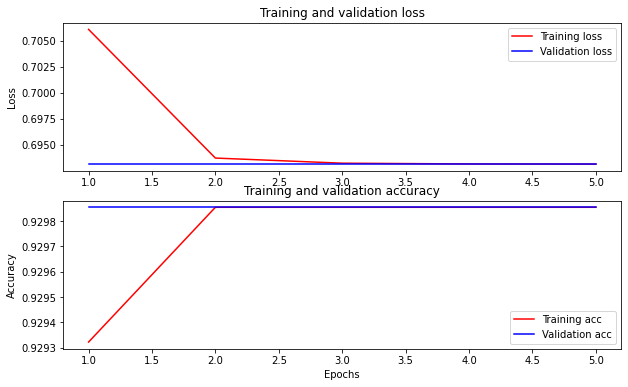

In [17]:
# Plot accuracy and loss
history_dict = train_history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [18]:
# Save architecture model
config = model.to_json()
model_config_path = f"[{bert_model_name}]{model_name}_V{model_ver}_{max_seq_len}.json"
with open(model_config_path, "w") as outfile:
    json.dump(config, outfile)

In [19]:
model.load_weights(model_ckpt_path)
y_pred_proba = model.predict(data.test_x)
get_metrics(data.test_y, y_pred_proba)

ACCURACY_SCORE:  0.9299
F1_SCORE:  0.4818
ROC_AUC_SCORE:  0.5
CONFUSION_MATRIX:
 [[29720     0]
 [ 2242     0]] 



# comparison between the models

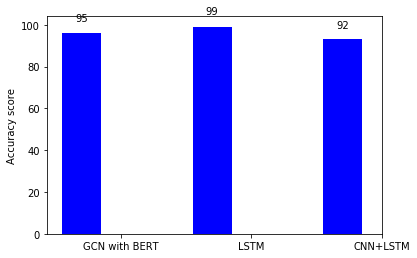

In [16]:
import numpy as np
import matplotlib.pyplot as plt

N = 3
ind = np.arange(N)  # the x locations for the groups
width = 0.3      # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

yvals = [bert_acc*100,lstm_acc,cnn_lstm_acc*100]

rects1 = ax.bar(ind, yvals, width, color='b')



ax.set_ylabel('Accuracy score')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('GCN with BERT','LSTM','CNN+LSTM') )
#ax.legend( (rects1[0]), ('Accuracy') )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')

autolabel(rects1)


plt.show()

In [25]:
score = bert_acc*100,lstm_acc,cnn_lstm_acc*100
#make variabel for save the result and to show it
classifier = ('GCN with BERT','LSTM','CNN+LSTM')
y_pos = np.arange(len(classifier))
print(y_pos)
print(score)

[0 1 2]
(95.86206896551724, 99.09, 92.99)


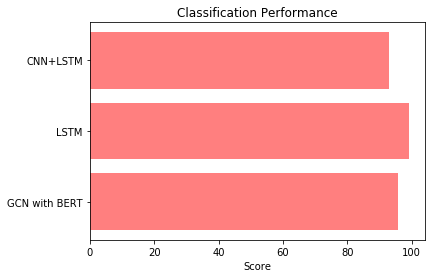

In [26]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, score, align='center', alpha=0.5,color='red')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Score')
plt2.title('Classification Performance')
plt2.show()